In [8]:
!pip install scipy
!pip install pandas
!pip install numpy
!pip install matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 2.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 5.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 5.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 6.7 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.9 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 4.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 8.1 MB/s eta 0:00:00


In [12]:
import numpy as np
import pandas as pd
from scipy.fft import ifft2


# Tamaño de la imagen y plano uv
N = 128  # Tamaño de la imagen (N x N)
uv_size = 256  # Tamaño del plano uv

# Valores de ∆x en arcsegundos
delta_x_arcsec = 2.0
# Conversión de arcsec a radianes
delta_x_rad = (np.pi / 180 / 3600) * delta_x_arcsec

# Cargar los datos desde el archivo CSV
data = pd.read_csv("hltau_completo_uv.csv", header=None, names=["uk", "vk", "wk", "real", "imag", "weight", "frequency", "channel"])
#Data
print(data)

# Matrices para F_r, F_i y W_t
F_r = np.zeros((N, N), dtype=np.complex128)
F_i = np.zeros((N, N), dtype=np.complex128)
W_t = np.zeros((N, N), dtype=float)


# Proceso de gridding
for index, row in data.iterrows():
    print("i: ", index)
    u_lam = row["uk"]  # Valores transformados a longitudes de onda
    v_lam = row["vk"]
    weight = row["weight"]  # Peso

    # Calcular ik y jk
    ik = int(np.round(u_lam / delta_x_rad + N / 2))
    jk = int(np.round(v_lam / delta_x_rad + N / 2))

    # Acumular los valores en las matrices locales
    if 0 <= ik < N and 0 <= jk < N:
        F_r[ik, jk] += weight * (row["real"] + 1j * row["imag"])
        F_i[ik, jk] += weight * (row["real"] + 1j * row["imag"])
        W_t[ik, jk] += weight


# Normalizar
# Verificar si W_t es igual a cero antes de la división
non_zero_indices = W_t != 0

# Dividir F_r y F_i solo en las celdas donde W_t no es cero
F_r[non_zero_indices] /= W_t[non_zero_indices]
F_i[non_zero_indices] /= W_t[non_zero_indices]


# Realizar la Transformada de Fourier Inversa para obtener la imagen sucia
dirty_image = np.abs(ifft2(F_r + 1j * F_i))



                  uk          vk          wk      real      imag      weight  \
0       -2245.512935 -625.275579 -404.967700  0.019848 -0.009888  12065070.0   
1       -2245.512935 -625.275579 -404.967700 -0.000239 -0.023323  12001271.0   
2       -2245.512935 -625.275579 -404.967700  0.005969 -0.014794  12065070.0   
3       -2245.512935 -625.275579 -404.967700 -0.003359 -0.009349  12001271.0   
4       -2245.512935 -625.275579 -404.967700 -0.011006 -0.024791  12065070.0   
...              ...         ...         ...       ...       ...         ...   
3196371   -49.627602   28.421167   68.651999  0.811038  0.068833  11467541.0   
3196372   -49.627602   28.421167   68.651999  0.764876  0.124828  11166644.0   
3196373   -49.627602   28.421167   68.651999  0.784313  0.060222  11467541.0   
3196374   -49.627602   28.421167   68.651999  0.767079  0.140298  11166644.0   
3196375   -49.627602   28.421167   68.651999  0.808210  0.059672  11467541.0   

            frequency  channel  
0     

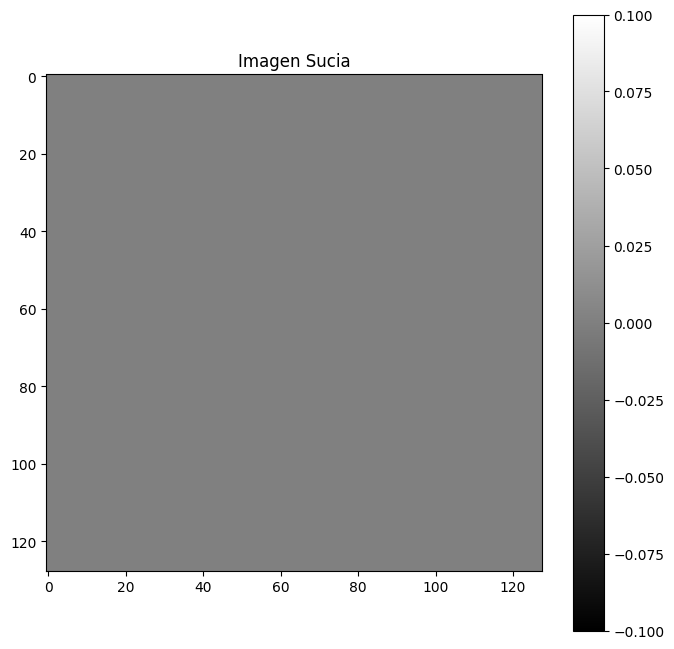

In [11]:
import matplotlib.pyplot as plt
# Mostrar la imagen sucia
plt.figure(figsize=(8, 8))
plt.imshow(dirty_image, cmap='gray')
plt.title('Imagen Sucia')
plt.colorbar()
plt.show()

In [48]:
%%file lab1.py

from mpi4py import MPI
import numpy as np
import pandas as pd
from scipy.fft import ifft2
import sys
import mpi4py.MPI as MPI
import ctypes


# Función para realizar el proceso de gridding en cada proceso
def grid_data(local_data, N, delta_x_rad):
    # Matrices para F_r, F_i y W_t locales
    local_F_r = np.zeros((N, N), dtype=np.complex128)
    local_F_i = np.zeros((N, N), dtype=np.complex128)
    local_W_t = np.zeros((N, N), dtype=float)

    for row in local_data:
        u_lam = row[0]  # Valores transformados a longitudes de onda
        v_lam = row[1]
        weight = row[5]  # Peso

        # Calcular ik y jk
        ik = int(np.round(u_lam / delta_x_rad + N / 2))
        jk = int(np.round(v_lam / delta_x_rad + N / 2))

        # Acumular los valores en las matrices locales
        if 0 <= ik < N and 0 <= jk < N:
            local_F_r[ik, jk] += weight * (row[2] + 1j * row[3])
            local_F_i[ik, jk] += weight * (row[2] + 1j * row[3])
            local_W_t[ik, jk] += weight

    return local_F_r, local_F_i, local_W_t

# Inicializar MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Obtener argumentos de línea de comandos
if len(sys.argv) != 7:
    print("Uso: mpirun -n numeroprocesos python lab1.py -i datosuv.csv -d deltax -N tamañoimagen")
    sys.exit(1)

if sys.argv[1] != '-i':
    print("Error: Debes especificar el archivo de datos con -i")
    sys.exit(1)

if sys.argv[3] != '-d':
    print("Error: Debes especificar el valor de deltax con -d")
    sys.exit(1)

if sys.argv[5] != '-N':
    print("Error: Debes especificar el tamaño de la imagen con -N")
    sys.exit(1)

input_file = sys.argv[2]
deltax = float(sys.argv[4])
N = int(sys.argv[6])

if rank == 0:
    # Proceso con rank 0 lee los datos del archivo de entrada
    data = pd.read_csv("hltau_completo_uv.csv", header=None, names=["uk", "vk", "wk", "real", "imag", "weight", "frequency", "channel"])
    data = data.values
    print(data)
    print("leyo la data")

    # Divide los datos en partes para cada proceso
    data_split = np.array_split(data, size, axis=0)
else:
    data_split = None

# Repartir los datos a todos los procesos
local_data = comm.scatter(data_split, root=0)


# Parámetros de la imagen y gridding
uv_size = 256  # Tamaño del plano uv
delta_x_arcsec = deltax  # Valor ∆x en arcsegundos
delta_x_rad = (np.pi / 180 / 3600) * delta_x_arcsec

# Realizar el proceso de gridding en cada proceso
local_F_r, local_F_i, local_W_t = grid_data(local_data, N, delta_x_rad)

if rank == 0:
    # Tamaño de datos que se espera recibir (en bytes)
    expected_data_size = N * N * (2 * np.complex128().itemsize + np.float64().itemsize)

    # Crear un búfer lo suficientemente grande para acomodar los datos
    buffer_size = size * expected_data_size
    buffer = np.empty(buffer_size, dtype=np.uint8)

    # Divide los datos en partes para cada proceso
    data_split = np.array_split(data, size, axis=0)


if rank == 0:
    # Recolectar las matrices locales
    comm.Gather(local_F_r, buffer, root=0)
    comm.Gather(local_F_i, buffer, root=0)
    comm.Gather(local_W_t, buffer, root=0)
    print("Gather se ejecutó, van al rank 0")



#comm.Gather(local_F_r, global_F_r, root=0)
#comm.Gather(local_F_i, global_F_i, root=0)
#comm.Gather(local_W_t, global_W_t, root=0)

print("Gatter se ejcuto, van al rank 0")
if rank == 0:
    # Proceso con rank 0 suma todas las matrices
    # Verificar si W_t es igual a cero antes de la división
    non_zero_indices = global_W_t != 0

    # Dividir F_r y F_i solo en las celdas donde W_t no es cero
    global_F_r[non_zero_indices] /= global_W_t[non_zero_indices]
    global_F_i[non_zero_indices] /= global_W_t[non_zero_indices]

    # Realizar la Transformada de Fourier Inversa para obtener la imagen sucia
    dirty_image = np.abs(ifft2(global_F_r + 1j * global_F_i))

    # Mostrar la imagen sucia
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 8))
    plt.imshow(dirty_image, cmap='gray')
    plt.title('Imagen Sucia')
    plt.colorbar()
    plt.show()


Overwriting lab1.py


In [ ]:
!mpirun -n 4 python lab1.py -i hltau_completo_uv.csv -d 0.001 -N 256

Gatter se ejcuto, van al rank 0
Gatter se ejcuto, van al rank 0
Gatter se ejcuto, van al rank 0


In [12]:
print("ola")

ola
